# Qwen Performance Confusion Matrix Analysis

This notebook evaluates Qwen model performance with 4 confusion matrices:
1. Presence Detection (Binary)
2. Appearance Year (±2 Year Tolerance)
3. Transition Detection (Binary)
4. Transition Year (±2 Year Tolerance)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

In [2]:
# Helper function to plot confusion matrices
def plot_confusion_matrix(cm, title, figsize=(8, 6), annot=True, fmt='d', cmap='Blues', save_name=None):
    """
    Plot a confusion matrix as a heatmap
    
    Args:
        cm: confusion matrix (pandas crosstab or DataFrame)
        title: title for the plot
        figsize: figure size
        annot: whether to annotate cells with values
        fmt: format for annotations
        cmap: colormap
        save_name: filename to save the plot (without extension)
    """
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt=fmt, cmap=cmap, cbar=True, 
                linewidths=0.5, linecolor='gray')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Ground Truth', fontsize=12)
    plt.xlabel('Prediction', fontsize=12)
    plt.tight_layout()
    
    # Save figure if save_name is provided
    if save_name:
        save_path = os.path.join('figures', f'{save_name}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to: {save_path}")
    
    plt.show()

In [3]:
# Load data
gt_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi GT.csv"
pred_path = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/"
    "model_prediction_csv/qwen_kiln_stats_delhi_all_loc_cleaned.csv"
)

gt = pd.read_csv(gt_path)
pred = pd.read_csv(pred_path)

print(f"Ground Truth samples: {len(gt)}")
print(f"Prediction samples: {len(pred)}")

# Prepare keys for merging
gt["key"] = gt["filename"].astype(str).str.replace(".png", "", regex=False)
pred["key"] = pred["lat_lon"].astype(str)

print(f"\nGround Truth columns: {gt.columns.tolist()}")
print(f"Prediction columns: {pred.columns.tolist()}")

Ground Truth samples: 924
Prediction samples: 924

Ground Truth columns: ['filename', 'class_name', 'presence', 'appearance_year', 'fcb_to_zigzag_Category', 'key']
Prediction columns: ['lat_lon', 'presence', 'appearance_year', 'shape_transition_year_before', 'shape_transition_year_after', 'key']


In [4]:
# Helper functions for metrics
def f1_macro(y_true, y_pred):
    labels = sorted(set(y_true) | set(y_pred))
    f1s = []
    for label in labels:
        tp = ((y_true == label) & (y_pred == label)).sum()
        fp = ((y_true != label) & (y_pred == label)).sum()
        fn = ((y_true == label) & (y_pred != label)).sum()
        denom = (2 * tp + fp + fn)
        f1s.append((2 * tp / denom) if denom else 0.0)
    return sum(f1s) / len(f1s) if f1s else 0.0

def f1_weighted(y_true, y_pred):
    labels = sorted(set(y_true) | set(y_pred))
    total = len(y_true)
    f1_sum = 0.0
    for label in labels:
        tp = ((y_true == label) & (y_pred == label)).sum()
        fp = ((y_true != label) & (y_pred == label)).sum()
        fn = ((y_true == label) & (y_pred != label)).sum()
        denom = (2 * tp + fp + fn)
        f1 = (2 * tp / denom) if denom else 0.0
        support = (y_true == label).sum()
        f1_sum += f1 * support
    return f1_sum / total if total else 0.0

## 1. Presence Detection (Binary)

Merged rows: 924

Confusion Matrix (Presence):
Prediction     0    1
Ground Truth         
0             93   78
1              0  753

Metrics:
TP: 753
TN: 93
FP: 78
FN: 0
Accuracy: 0.9156
Precision: 0.9061
Recall: 1.0000
F1-Score: 0.9508
Saved figure to: figures/qwen_presence_confusion_matrix.png


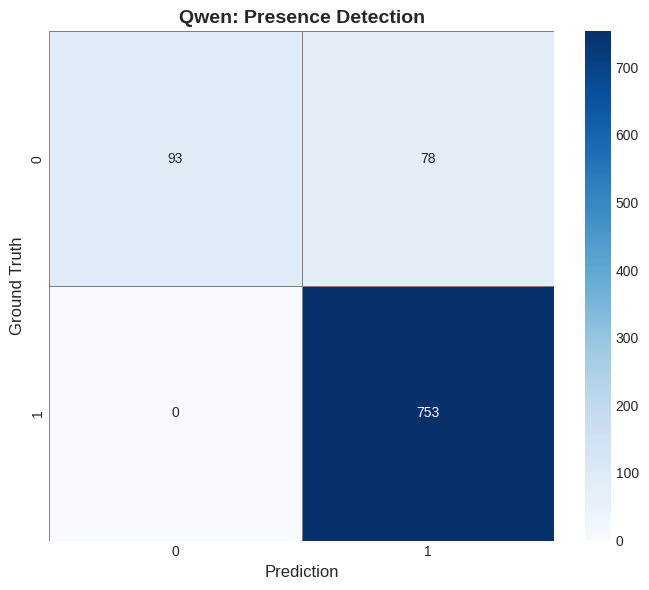

In [5]:
# Prepare presence data
gt["presence"] = pd.to_numeric(gt["presence"], errors="coerce").fillna(0).astype(int)
pred["presence"] = pd.to_numeric(pred["presence"], errors="coerce").fillna(0).astype(int)

# Merge
merged_presence = gt.merge(pred[["key", "presence"]], on="key", how="inner", suffixes=("_gt", "_pred"))
print(f"Merged rows: {len(merged_presence)}")

# Create confusion matrix
cm_presence = pd.crosstab(
    merged_presence["presence_gt"], 
    merged_presence["presence_pred"], 
    rownames=["Ground Truth"], 
    colnames=["Prediction"], 
    dropna=False
).reindex(index=[0, 1], columns=[0, 1], fill_value=0)

print("\nConfusion Matrix (Presence):")
print(cm_presence)

# Calculate metrics
TN = int(cm_presence.loc[0, 0])
FP = int(cm_presence.loc[0, 1])
FN = int(cm_presence.loc[1, 0])
TP = int(cm_presence.loc[1, 1])

metrics_presence = {
    "TP": TP,
    "TN": TN,
    "FP": FP,
    "FN": FN,
    "Accuracy": (TP + TN) / max(TP + TN + FP + FN, 1),
    "Precision": TP / max(TP + FP, 1),
    "Recall": TP / max(TP + FN, 1),
    "F1-Score": (2 * TP) / max(2 * TP + FP + FN, 1),
}

print("\nMetrics:")
for k, v in metrics_presence.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Visualize
plot_confusion_matrix(
    cm_presence,
    title='Qwen: Presence Detection',
    figsize=(7, 6),
    cmap='Blues',
    save_name='qwen_presence_confusion_matrix'
)

## 2. Appearance Year (±2 Year Tolerance)

Merged rows: 924
Predictions adjusted: 822 out of 924

Confusion Matrix (Appearance Year with ±2y tolerance):
Prediction (±2y)  0     2014  2016  2018  2020  2022
Ground Truth                                        
0                   93    39    25    13     4     0
2014                 0   592     0     0     0     0
2016                 0     0   102     0     0     0
2018                 0     8     0    28     0     0
2020                 0     4     0     0     4     0
2022                 0     6     3     0     0     3

Metrics (Appearance Year with ±2y tolerance):
Accuracy: 0.8896
F1-Macro: 0.6929
F1-Weighted: 0.8774
Saved figure to: figures/qwen_appearance_year_tolerance_confusion_matrix.png


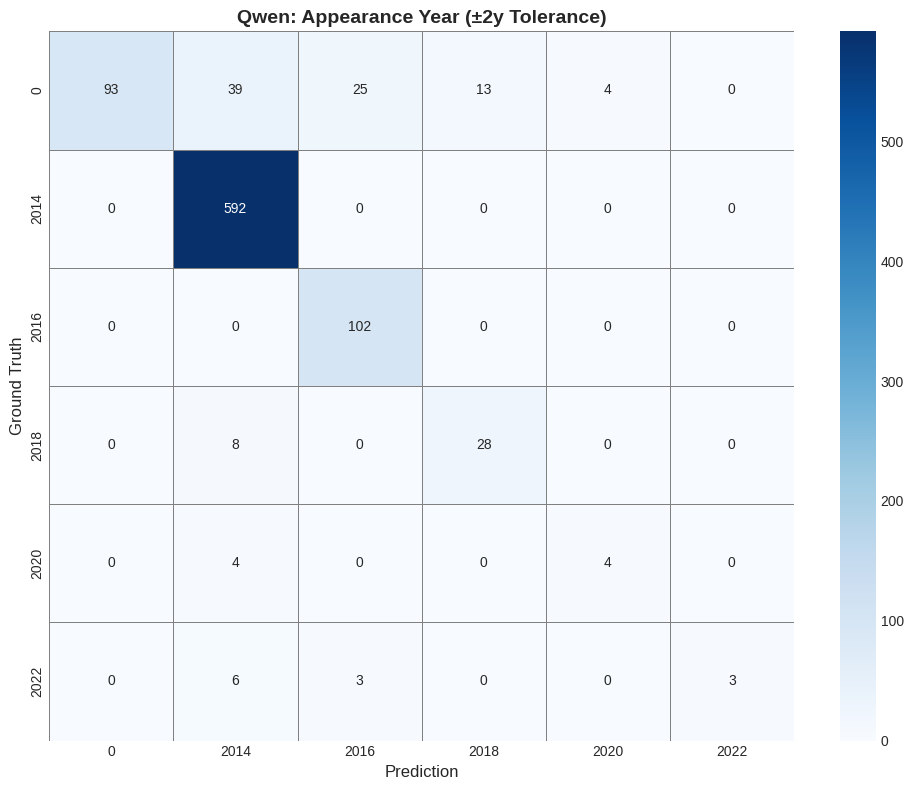

In [6]:
# Prepare appearance year data
gt["appearance_year"] = pd.to_numeric(gt["appearance_year"], errors="coerce").fillna(0).astype(int)
pred["appearance_year"] = pd.to_numeric(pred["appearance_year"], errors="coerce").fillna(0).astype(int)

# Merge
merged_appearance = gt.merge(
    pred[["key", "appearance_year"]],
    on="key",
    how="inner",
    suffixes=("_gt", "_pred"),
)

print(f"Merged rows: {len(merged_appearance)}")

# Apply ±2 year tolerance
tol = 2
y_true = merged_appearance["appearance_year_gt"]
y_pred = merged_appearance["appearance_year_pred"].copy()

mask = (y_true - y_pred).abs() <= tol
y_pred[mask] = y_true[mask]

print(f"Predictions adjusted: {mask.sum()} out of {len(mask)}")

# Create confusion matrix
cm_appearance = pd.crosstab(
    y_true,
    y_pred,
    rownames=["Ground Truth"],
    colnames=["Prediction (±2y)"],
    dropna=False,
)

print("\nConfusion Matrix (Appearance Year with ±2y tolerance):")
print(cm_appearance)

# Calculate metrics
accuracy = (y_true == y_pred).mean()

metrics_appearance = {
    "Accuracy": accuracy,
    "F1-Macro": f1_macro(y_true, y_pred),
    "F1-Weighted": f1_weighted(y_true, y_pred),
}

print("\nMetrics (Appearance Year with ±2y tolerance):")
for k, v in metrics_appearance.items():
    print(f"{k}: {v:.4f}")

# Visualize
plot_confusion_matrix(
    cm_appearance,
    title='Qwen: Appearance Year (±2y Tolerance)',
    figsize=(10, 8),
    cmap='Blues',
    save_name='qwen_appearance_year_tolerance_confusion_matrix'
)

## 3. Transition Detection (Binary)

Merged rows: 924
Ground truth transitions: 671 out of 924
Predicted transitions: 375 out of 924

Confusion Matrix (Transition Detection):
Prediction      0    1
Ground Truth          
0             170   83
1             379  292

Metrics (Transition Detection):
TP: 292
TN: 170
FP: 83
FN: 379
Accuracy: 0.5000
Precision: 0.7787
Recall: 0.4352
F1-Score: 0.5583
Saved figure to: figures/qwen_transition_detection_confusion_matrix.png


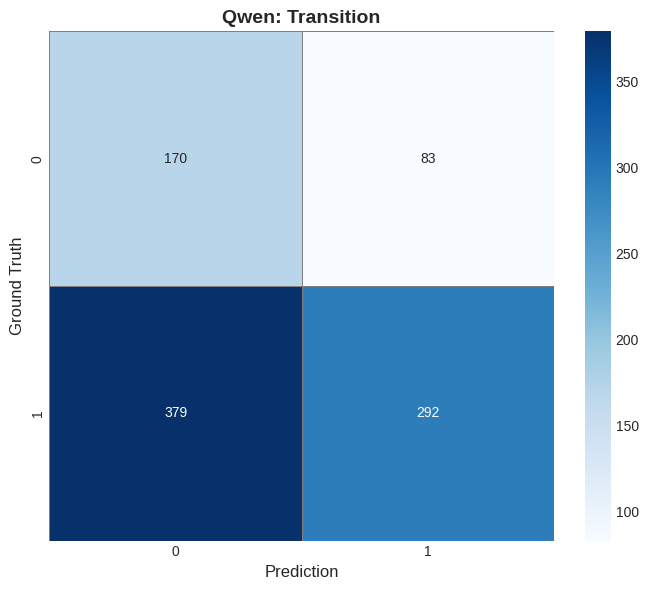

In [7]:
# Prepare transition data
gt_col = "fcb_to_zigzag_Category"
pred_col = "shape_transition_year_after"

# Normalize columns
gt[gt_col] = pd.to_numeric(gt[gt_col], errors="coerce").fillna(0).astype(int)
pred[pred_col] = pd.to_numeric(pred[pred_col], errors="coerce").fillna(0).astype(int)

# Merge
merged_transition = gt.merge(
    pred[["key", pred_col]],
    on="key",
    how="inner",
)

print(f"Merged rows: {len(merged_transition)}")

# Binary transition detection (existence)
y_true_year = merged_transition[gt_col].values
y_pred_year = merged_transition[pred_col].values

# Convert to binary (0 = no transition, 1 = transition exists)
y_true_bin = (y_true_year != 0).astype(int)
y_pred_bin = (y_pred_year != 0).astype(int)

print(f"Ground truth transitions: {y_true_bin.sum()} out of {len(y_true_bin)}")
print(f"Predicted transitions: {y_pred_bin.sum()} out of {len(y_pred_bin)}")

# Create confusion matrix
cm_transition = pd.crosstab(
    y_true_bin,
    y_pred_bin,
    rownames=["Ground Truth"],
    colnames=["Prediction"],
).reindex(index=[0, 1], columns=[0, 1], fill_value=0)

print("\nConfusion Matrix (Transition Detection):")
print(cm_transition)

# Calculate metrics
TN_trans = int(cm_transition.loc[0, 0])
FP_trans = int(cm_transition.loc[0, 1])
FN_trans = int(cm_transition.loc[1, 0])
TP_trans = int(cm_transition.loc[1, 1])

metrics_transition = {
    "TP": TP_trans,
    "TN": TN_trans,
    "FP": FP_trans,
    "FN": FN_trans,
    "Accuracy": (TP_trans + TN_trans) / max(TP_trans + TN_trans + FP_trans + FN_trans, 1),
    "Precision": TP_trans / max(TP_trans + FP_trans, 1),
    "Recall": TP_trans / max(TP_trans + FN_trans, 1),
    "F1-Score": (2 * TP_trans) / max(2 * TP_trans + FP_trans + FN_trans, 1),
}

print("\nMetrics (Transition Detection):")
for k, v in metrics_transition.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Visualize
plot_confusion_matrix(
    cm_transition,
    title='Qwen: Transition',
    figsize=(7, 6),
    cmap='Blues',
    save_name='qwen_transition_detection_confusion_matrix'
)

## 4. Transition Year (±2 Year Tolerance)

Predictions adjusted: 137 out of 924

Confusion Matrix (Transition Year with ±2y tolerance):
Prediction (±2y)  0     2016  2018  2020  2022  2024
Ground Truth                                        
0                  170    30    22    16     9     6
2016                 2     0     0     0     0     0
2018                22     0    26     0     1     0
2020               119    34     0    46     0     1
2022               202    57    43     0    62     0
2023                 0     0     1     0     0     0
2024                34     7     8     3     0     3

Metrics (Transition Year with ±2y tolerance):
Accuracy: 0.3323
F1-Macro: 0.2138
F1-Weighted: 0.3273
Saved figure to: figures/qwen_transition_year_tolerance_confusion_matrix.png


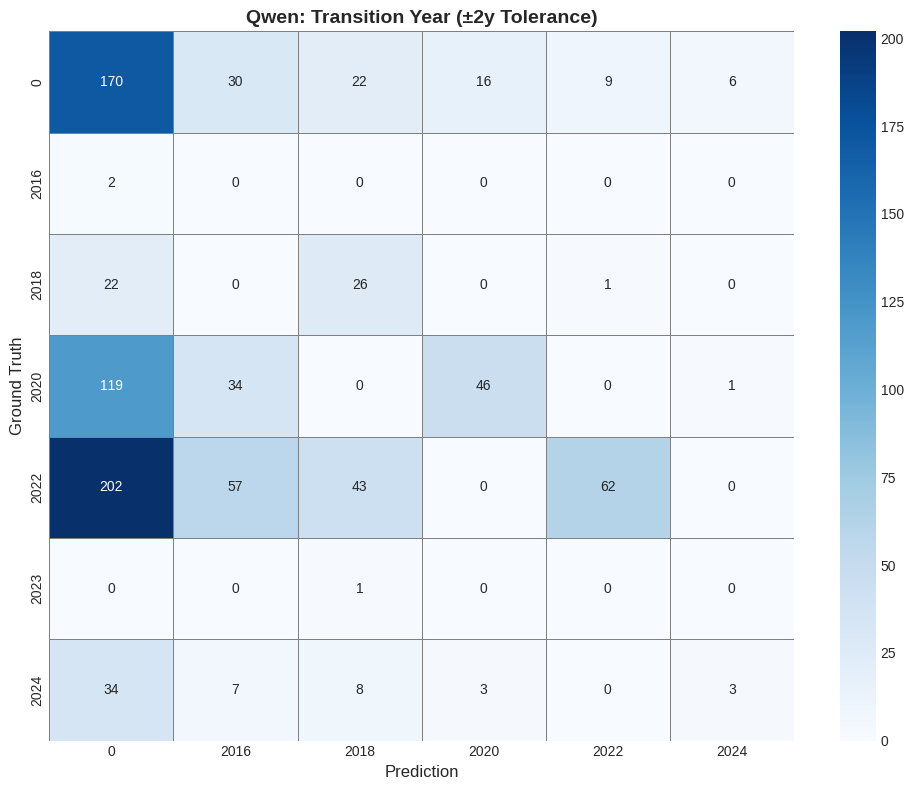

In [9]:
# Apply ±2 year tolerance to transition years
tol = 2
y_true_trans = merged_transition[gt_col].values
y_pred_trans = merged_transition[pred_col].values.copy()

# Adjust predictions within ±2 years to match ground truth
mask_trans = (y_true_trans != 0) & (y_pred_trans != 0) & (np.abs(y_pred_trans - y_true_trans) <= tol)
y_pred_trans[mask_trans] = y_true_trans[mask_trans]

print(f"Predictions adjusted: {mask_trans.sum()} out of {len(mask_trans)}")

# Create confusion matrix
cm_transition_year = pd.crosstab(
    y_true_trans,
    y_pred_trans,
    rownames=["Ground Truth"],
    colnames=["Prediction (±2y)"],
    dropna=False,
)

print("\nConfusion Matrix (Transition Year with ±2y tolerance):")
print(cm_transition_year)

# Calculate metrics
accuracy_trans = (y_true_trans == y_pred_trans).mean()

metrics_transition_year = {
    "Accuracy": accuracy_trans,
    "F1-Macro": f1_macro(y_true_trans, y_pred_trans),
    "F1-Weighted": f1_weighted(y_true_trans, y_pred_trans),
}

print("\nMetrics (Transition Year with ±2y tolerance):")
for k, v in metrics_transition_year.items():
    print(f"{k}: {v:.4f}")

# Visualize
plot_confusion_matrix(
    cm_transition_year,
    title='Qwen: Transition Year (±2y Tolerance)',
    figsize=(10, 8),
    cmap='Blues',
    save_name='qwen_transition_year_tolerance_confusion_matrix'
)